In [1]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import time
import librosa

In [1]:
class speech_feat_extract():
    
    def __init__(sessions, datapath, categories = ['ang', 'exc', 'neu', 'sad']):
        self.sessions = sessions
        self.datapath = datapath
        
        self.category_list = categories
        self.mfcc = {}
        self.zcr = {}
        self.pitch = {}
        self.mfcc_stat = {}
        self.zcr_stat = {}
        self.pitch_stat = {}
        
        self.id2label = {}
        self.label2ids = {}
        def parse_groundtruth(fpath):
            id2label = {}
            label2ids = {}
            for line in fpath:
                if line.startswith('['):
                    words = line.rstrip().split('\t')
                    id2label[words[1]] = words[2]
                    if label2ids.has_key(words[2]):
                        label2ids[words[2]].append(words[1])
                    else:
                        label2ids[words[2]] = words[1]
            return id2label, label2ids
        
        for session in sessions:
            for subdir, dirs, files in os.walk(datapath + session + '/dialog/EmoEvaluation/all'):
                for f in files:
                    fpath = subdir + os.sep + f
                    if fpath.endswith('.txt'):
                        self.id2label, self.label2ids = parse_groundtruth(fpath)
                        
        self.label2catid = {}
        for i in range(len(categories)):
            self.label2catid[categories[i]] = i+1
            
        self.wavpaths = self.filepath_helper('/sentences/wav', '.wav')
            
    def filepath_helper(relpath, filetype):
        filepaths = []
        for session in self.sessions:
            for subdir, dirs, files in os.walk(self.datapath + session + relpath):
                for f in files:
                    if f.endswith(filetype):
                        filepaths.append([subdir + os.sep + f, f[:-4]])
        return filepaths
                        
        
    def compute_mfcc():
        wavpath = '/sentences/wav/'
        filepaths = self.wavpaths
        print 'Computing MFCC for ' + str(len(filepaths)) + ' utterances'
        for f in filepaths:
            (rate,sig) = wav.read(f[0])
            self.mfcc[f[1]] = mfcc(sig,rate)
        
    def compute_zcr():
        filepaths = self.wavpaths
        for f in filepaths:
            sig, sr = librosa.load(f[0])
            zcr_feat[f[1]] = librosa.feature.zero_crossing_rate(sig)[0]
        
    def compute_pitch():
        filepaths = self.wavpaths
        for f in filepaths:
            subprocess.call(['/usr/bin/praat', '--run', 'extract_pitch.praat', f[0]])
            pitch = {}
            with open('temp.pitch') as fil:
                for i in fil:
                    val = i.split()
                    if val[1] != '--undefined--' and val[0] != 'Pitch':
                        pitch[float(val[0])] = float(val[1])
            self.pitch[f[1]] = pitch
        
    def compute_stat(feat):
        if feat == 'mfcc':
            X = self.mfcc
        elif feat == 'zcr':
            X = self.zcr
        
        X_mean = np.empty((0,13), float)
        X_var = np.empty((0,13), float)
        for k,v in X_feat.items():
            if self.id2label[k] in self.categories:
                A = np.mean(v, axis=0)
                X_mean = np.concatenate((X_mean, np.reshape(A, (-1, A.shape[0]))), axis=0)
                A = np.var(v, axis=0)
                X_var = np.concatenate((X_var, np.reshape(A, (-1, A.shape[0]))), axis=0)
                
        if feat == 'mfcc':
            self.mfcc_stat = list(np.concatenate((X_mean, X_var), axis = 1))
        elif feat == 'zcr':
            self.zcr_stat = list(np.concatenate((X_mean, X_var), axis=1))

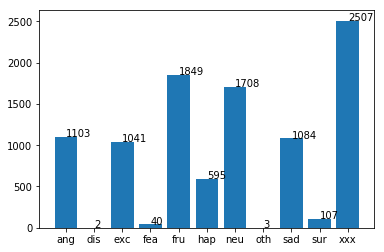

In [3]:
# analyzing the class distributions
with open('label2file.pkl') as f:
    label2file = pickle.load(f)

y = [len(v) for k,v in label2file.items()]
x = [k for k,v in label2file.items()]

plt.bar(x,y)
for i,v in enumerate(x):
    plt.text(v, y[i]+0.25, str(y[i]))
plt.show()

In [29]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=5)
acc = []
for train_index, test_index in kf.split(X):
    tr_x, te_x = X[train_index], X[test_index]
    tr_y, te_y = y[train_index], y[test_index]
    clf = svm.SVC()
    clf.fit(tr_x, tr_y)
    pred = clf.predict(te_x)
    acc.append(accuracy_score(te_y, pred))

print sum(acc)/float(len(acc))

0.34602648191673946
